In [5]:
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
files = glob(f'../data/interim/BehaviorEncoding/*.csv.gz')
df = []
for file in files:
    df.append(pd.read_csv(file))
df = pd.concat(df)

In [3]:
def get_max_score(group):
    return group.loc[group['score'].idxmax()]

df_avg = df.groupby(['feature', 'model_uid', 'metric', 'model_layer_index']).mean(numeric_only=True).reset_index()
df_avg.drop(columns=['k_fold'], inplace=True)
max_scores = df_avg.groupby(['feature', 'model_uid', 'metric']).apply(get_max_score).reset_index(drop=True)

/tmp/ipykernel_351901/26847533.py:2: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.barplot(x='feature', y='score', hue='metric', data=max_scores,


<Axes: xlabel='feature', ylabel='score'>

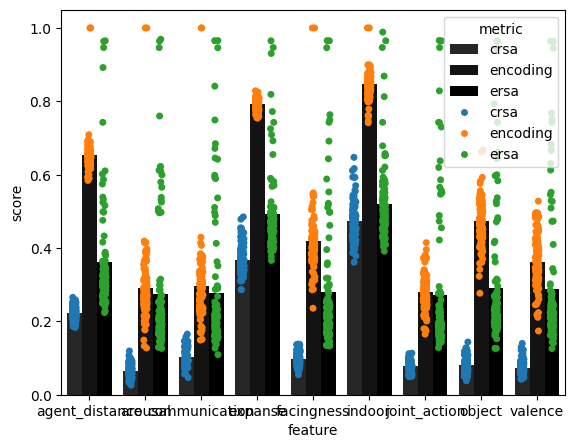

In [19]:
_, ax = plt.subplots(figsize=(6.5,5))
sns.barplot(x='feature', y='score', hue='metric', data=max_scores,
              ax=ax, dodge=True, errorbar=None, color='black', zorder=0)
sns.stripplot(x='feature', y='score', hue='metric', data=max_scores,
              ax=ax, dodge=True, jitter=True, zorder=1)